In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from skimage.morphology import remove_small_holes, skeletonize
import pandas as pd
from matplotlib import animation
from matplotlib import rcParams
from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from pyfcd.fcd import calculate_carriers, fcd, normalize_image

THRESHOLD = 120
MAX_PIXEL_VALUE = 255
MM2_CALIBRATION = 1000*(924)*1e-6  #largo*(diametro) de la cabecilla [µm^2 -> mm^2]

plt.style.use("default")
COLOR = 'black'

# FIGURE & AXES
rcParams['figure.figsize'] = (15,10)
rcParams['figure.dpi'] = 70
rcParams['axes.grid'] = True
# rcParams['axes.xmargin'] = 0
rcParams['axes.labelcolor'] = COLOR
rcParams['axes.facecolor'] = '#ebebeb'
rcParams['axes.grid.axis'] = 'both'
rcParams['axes.axisbelow'] = True
rcParams['text.color'] = COLOR
rcParams['text.color'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR
rcParams['grid.color'] = COLOR


# FONT
rcParams["font.family"] = "serif"
rcParams["mathtext.fontset"] = "cm"
rcParams['axes.titlesize'] = 36
rcParams['axes.labelsize'] = 36
rcParams['ytick.labelsize'] = 22
rcParams['xtick.labelsize'] = 22
rcParams['legend.fontsize'] = 28
rcParams['legend.title_fontsize'] = 28

rcParams['text.latex.preamble'] = "\n".join([
    r'\usepackage[version=3]{mhchem}'
])

# SAVE
# rcParams['savefig.format'] = 'pdf'
rcParams['savefig.bbox'] = 'tight'
# rcParams['savefig.pad_inches'] = 0.05

In [2]:
def cortar(frame, limites, PRUEBA=False, nombre='CORTE'):
    # lee en gris
    min_x, max_x, min_y, max_y = limites
    corte = frame[min_y:max_y, min_x:max_x] # resolver lo del corte binarizadp
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', corte)
    return corte

def gris(frame, PRUEBA=False, nombre='GRAYSCALE'):
    im_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', im_gray)
    return im_gray

def binarize(frame, PRUEBA=False, nombre='BINARY', threshold = THRESHOLD):
    # im_binary = cv.adaptiveThreshold(frame, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)
    _, im_binary = cv.threshold(frame, threshold, MAX_PIXEL_VALUE, cv.THRESH_BINARY)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', im_binary)
    return im_binary

def obtener_deformacion(vs, lim, carriers, SHOW=False):
    frame_count = int(vs.get(7))
    i=0
    maps = np.zeros(frame_count, dtype=object)
    while(vs.isOpened()):
        ret, frame = vs.read()
        if ret:            
            frame = gris(cortar(frame, lim))
            height_map = fcd(frame, carriers)
            maps[i] = height_map
            if SHOW:
                cv.imshow('frame', frame)
            if cv.waitKey(1) & 0xFF == ord('q'):
                break
            i+=1
        else:
            break
        
    cv.destroyAllWindows()
    return maps

# P2-2V-9Hz

In [ ]:
vs = cv.VideoCapture('videos/FCD/P2-2V-9Hz.mp4')
i=0
while(vs.isOpened()):
    ret, frame = vs.read()
    if ret: 
        if i==0:
            ref_frame = gris(frame)
        cv.imshow('frame', frame)
        i+=1
        if cv.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
cv.destroyAllWindows()

In [ ]:
plt.imshow(ref_frame[200:475,400:1050])

In [ ]:
vs = cv.VideoCapture('videos/FCD/P2-2V-9Hz.mp4')
i=0
while(vs.isOpened()):
    ret, frame = vs.read()
    if ret: 
        frame = gris(frame[200:475,400:1050])
        if i==0:
            ref_frame = frame
        cv.imshow('frame', frame)
        i+=1
        if cv.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
cv.destroyAllWindows()

In [ ]:
vs = cv.VideoCapture('videos/FCD/P2-2V-9Hz.mp4')
lim = [400,1050,200,475]

carriers = calculate_carriers(ref_frame)

maps = obtener_deformacion(vs,lim,carriers, SHOW=True)

In [ ]:

max_height = max([maps[i].max() for i in np.arange(len(maps))])

norm = plt.Normalize(-max_height, max_height)
cmap = plt.colormaps.get_cmap('seismic')
colorscale = plt.cm.ScalarMappable(norm, cmap)

for i in np.arange(len(maps)):
    fig, ax = plt.subplots()
    im = ax.imshow(maps[i],cmap=cmap, aspect='equal')

    cbar_term = fig.colorbar(colorscale, ax=ax, location='right', orientation='vertical', pad=0, fraction=0.0209)
    cbar_term.ax.set_ylim(-max_height,max_height)
    cbar_term.ax.ticklabel_format(axis='x',style='sci',scilimits=(0,2))
    cbar_term.ax.set_ylabel('Altura',labelpad=40)
    fig.tight_layout()
    # fig.savefig(f'schlieren_maps/P2_2V_9Hz/images/{str(i)}.tiff')

In [ ]:
start = 0
finish = 830
length = finish-start
x_len = maps[0].shape[1]
y_len = maps[0].shape[0]

map_fft = np.zeros((length,y_len,x_len), dtype=np.complex128)
reduced_maps = maps[start:finish]
for i in np.arange(len(reduced_maps)):
    map_fft[i] = np.fft.fft2(reduced_maps[i])

In [ ]:
fig,ax = plt.subplots()

sum_fft = np.zeros(shape=(y_len,x_len), dtype=np.float64)
for i in np.arange(len(map_fft)):
    sum_fft+=(np.abs(np.fft.fftshift(map_fft[i]))**2)

ax.imshow(np.log(sum_fft), cmap='viridis', aspect='equal')

# P1-2V-9Hz

In [3]:
vs = cv.VideoCapture('videos/FCD/P1-2V-9Hz.mp4')
i=0
while(vs.isOpened()):
    ret, frame = vs.read()
    if ret: 
        if i==0:
            ref_frame = gris(frame)
        cv.imshow('frame', frame)
        i+=1
        if cv.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
cv.destroyAllWindows()

In [ ]:
plt.imshow(ref_frame[200:450,450:950])
plt.show()

In [3]:
vs = cv.VideoCapture('videos/FCD/P1-2V-9Hz.mp4')
i=0
while(vs.isOpened()):
    ret, frame = vs.read()
    if ret: 
        frame = gris(frame[200:450,450:950])
        if i==0:
            ref_frame = frame
        cv.imshow('frame', frame)
        i+=1
        if cv.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
cv.destroyAllWindows()

In [4]:
vs = cv.VideoCapture('videos/FCD/P1-2V-9Hz.mp4')
lim = [450,950,200,450]

carriers = calculate_carriers(ref_frame)

maps = obtener_deformacion(vs,lim,carriers, SHOW=True)

In [15]:
max_height = max([maps[i].max() for i in np.arange(len(maps))])

norm = plt.Normalize(-max_height, max_height)
cmap = plt.colormaps.get_cmap('seismic')
colorscale = plt.cm.ScalarMappable(norm, cmap)

for i in np.arange(len(maps)):
    fig, ax = plt.subplots()
    im = ax.imshow(maps[i],cmap=cmap, aspect='equal')

    cbar_term = fig.colorbar(colorscale, ax=ax, location='right', orientation='vertical', pad=0, fraction=0.0209)
    cbar_term.ax.set_ylim(-max_height,max_height)
    cbar_term.ax.ticklabel_format(axis='x',style='sci',scilimits=(0,2))
    cbar_term.ax.set_ylabel('Altura',labelpad=40)
    fig.tight_layout()
    np.save(f'schlieren_maps/P1_2V_9Hz/frame_data/{str(i)}.npy',maps[i],allow_pickle=True)
    fig.savefig(f'schlieren_maps/P1_2V_9Hz/images/{str(i)}.tiff')
    plt.close()

: 

In [9]:
start = 330
finish = 660
length = finish-start
x_len = maps[0].shape[1]-1
y_len = maps[0].shape[0]-1

map_fft = np.zeros((length,y_len,x_len), dtype=np.complex128)
reduced_maps = maps[start:finish]
for i in np.arange(len(reduced_maps)):
    map_fft[i] = np.fft.fft2(reduced_maps[i])[1:,1:]

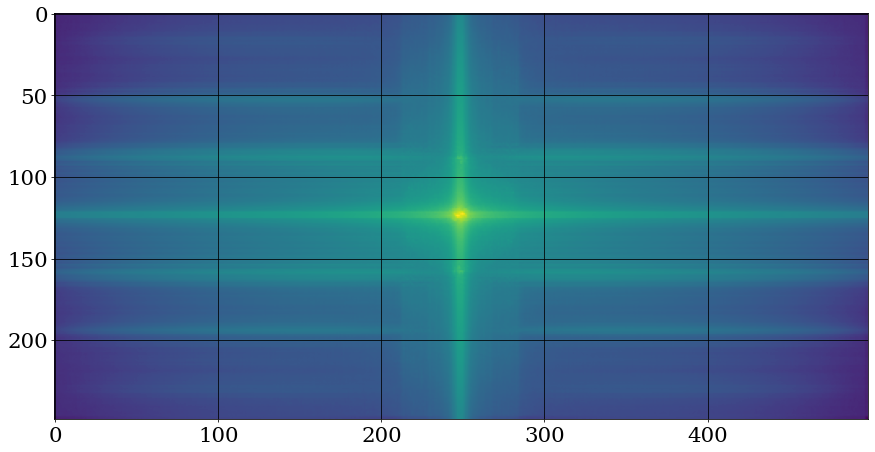

In [10]:
fig,ax = plt.subplots()

sum_fft = np.zeros(shape=map_fft[0].shape, dtype=np.float64)
for i in np.arange(len(map_fft)):
    sum_fft+=(np.abs(np.fft.fftshift(map_fft[i]))**2)

ax.imshow(np.log(sum_fft), cmap='viridis', aspect='equal')